# 付録A9: 優先的選択とスケールフリーネットワーク

このノートブックでは、ネットワークの成長過程における「優先的選択（Preferential Attachment）」のメカニズムと、それによって生じるスケールフリーネットワークについて学びます。

## 学習目標

- 優先的選択（Preferential Attachment）の概念を理解する
- Barabási-Albertモデルを実装・分析する
- べき乗則（Power Law）分布を理解・検出する
- 「富める者はますます富む」現象をシミュレーションする
- 異なるネットワーク成長モデルを比較する
- 実ネットワークでの優先的選択を測定する

## セットアップ

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
from collections import Counter
from scipy import stats
from scipy.optimize import curve_fit
import random

plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)
random.seed(42)

## 1. 優先的選択とは

### 1.1 基本概念

**優先的選択（Preferential Attachment）** は、「既に多くの接続を持つノードほど、新しい接続を獲得しやすい」という成長メカニズムです。

この現象は様々な名前で知られています：
- **マタイ効果（Matthew Effect）**: 「持てる者はさらに与えられる」（聖書の一節から）
- **富める者はますます富む（Rich-get-richer）**: 経済学での表現
- **累積的優位（Cumulative Advantage）**: 科学社会学での概念

### 1.2 数学的定式化

新しいノードが既存のノード $i$ に接続する確率は、そのノードの次数 $k_i$ に比例します：

$$\Pi(k_i) = \frac{k_i}{\sum_j k_j}$$

### 1.3 現実世界での例

| 分野 | 例 | 説明 |
|------|----|----- |
| WWW | ウェブページのリンク | 人気ページはさらにリンクされやすい |
| 学術 | 論文の引用 | 多く引用される論文はさらに引用される |
| SNS | フォロワー数 | 人気アカウントはさらにフォローされやすい |
| 経済 | 企業規模 | 大企業はさらに成長しやすい |
| 都市 | 人口 | 大都市はさらに人口を引きつける |

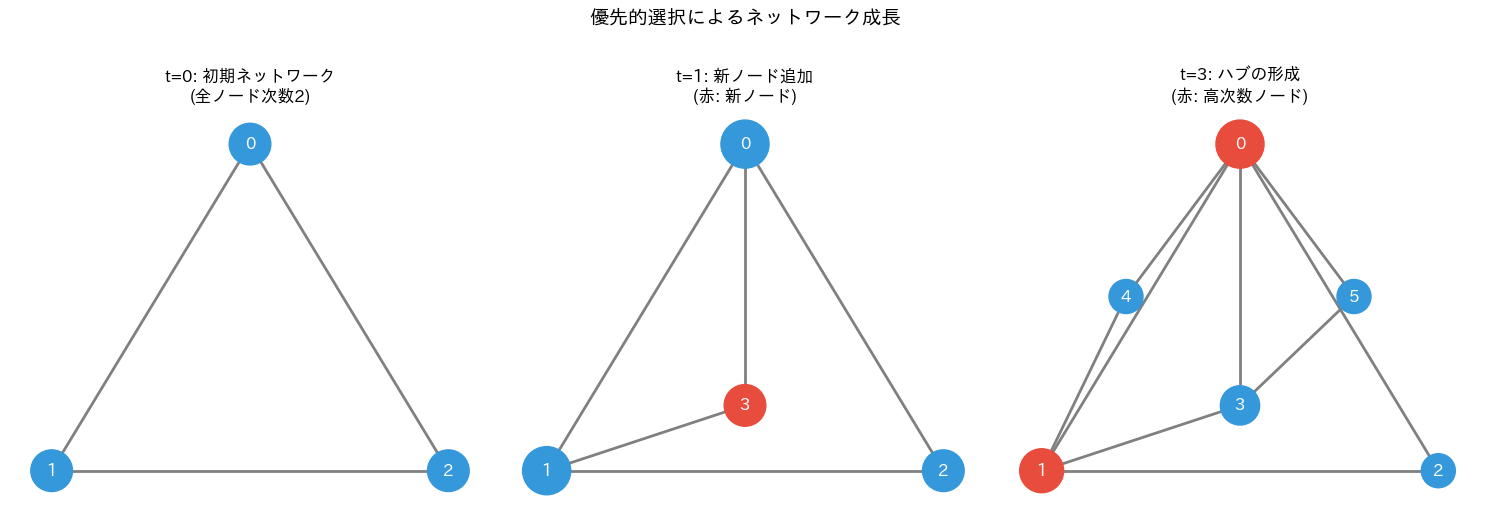

ノード0の次数: 2 → 3 → 5 (ハブへと成長)
新しいノードは既に次数の高いノードに接続しやすい


In [2]:
# 優先的選択の概念図
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ステップ1: 初期ネットワーク
ax1 = axes[0]
G1 = nx.complete_graph(3)
pos1 = {0: (0, 1), 1: (-0.87, -0.5), 2: (0.87, -0.5)}
node_sizes1 = [d * 300 + 300 for n, d in G1.degree()]
nx.draw(G1, pos1, ax=ax1, node_color='#3498db', node_size=node_sizes1,
        with_labels=True, font_color='white', font_weight='bold',
        edge_color='gray', width=2)
ax1.set_title('t=0: 初期ネットワーク\n(全ノード次数2)', fontsize=12)

# ステップ2: 新しいノードが追加
ax2 = axes[1]
G2 = G1.copy()
G2.add_node(3)
G2.add_edges_from([(3, 0), (3, 1)])  # 優先的に選択
pos2 = {0: (0, 1), 1: (-0.87, -0.5), 2: (0.87, -0.5), 3: (0, -0.2)}
node_sizes2 = [d * 300 + 300 for n, d in G2.degree()]
colors2 = ['#3498db', '#3498db', '#3498db', '#e74c3c']
nx.draw(G2, pos2, ax=ax2, node_color=colors2, node_size=node_sizes2,
        with_labels=True, font_color='white', font_weight='bold',
        edge_color='gray', width=2)
ax2.set_title('t=1: 新ノード追加\n(赤: 新ノード)', fontsize=12)

# ステップ3: さらに追加
ax3 = axes[2]
G3 = G2.copy()
G3.add_node(4)
G3.add_edges_from([(4, 0), (4, 1)])  # 次数の高いノードに接続
G3.add_node(5)
G3.add_edges_from([(5, 0), (5, 3)])
pos3 = {0: (0, 1), 1: (-0.87, -0.5), 2: (0.87, -0.5), 
        3: (0, -0.2), 4: (-0.5, 0.3), 5: (0.5, 0.3)}
node_sizes3 = [d * 200 + 200 for n, d in G3.degree()]
colors3 = ['#e74c3c' if G3.degree(n) >= 4 else '#3498db' for n in G3.nodes()]
nx.draw(G3, pos3, ax=ax3, node_color=colors3, node_size=node_sizes3,
        with_labels=True, font_color='white', font_weight='bold',
        edge_color='gray', width=2)
ax3.set_title('t=3: ハブの形成\n(赤: 高次数ノード)', fontsize=12)

plt.suptitle('優先的選択によるネットワーク成長', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("ノード0の次数: 2 → 3 → 5 (ハブへと成長)")
print("新しいノードは既に次数の高いノードに接続しやすい")

## 2. Barabási-Albertモデル

### 2.1 モデルの定義

Barabási-Albert (BA) モデル (1999) は、優先的選択を取り入れたネットワーク成長モデルです。

**アルゴリズム:**
1. $m_0$ 個のノードを持つ初期ネットワークから開始
2. 各タイムステップで、新しいノードを追加
3. 新しいノードは $m$ 本のエッジで既存ノードに接続
4. 既存ノード $i$ が選ばれる確率は $\Pi(k_i) = k_i / \sum_j k_j$

### 2.2 スクラッチからの実装

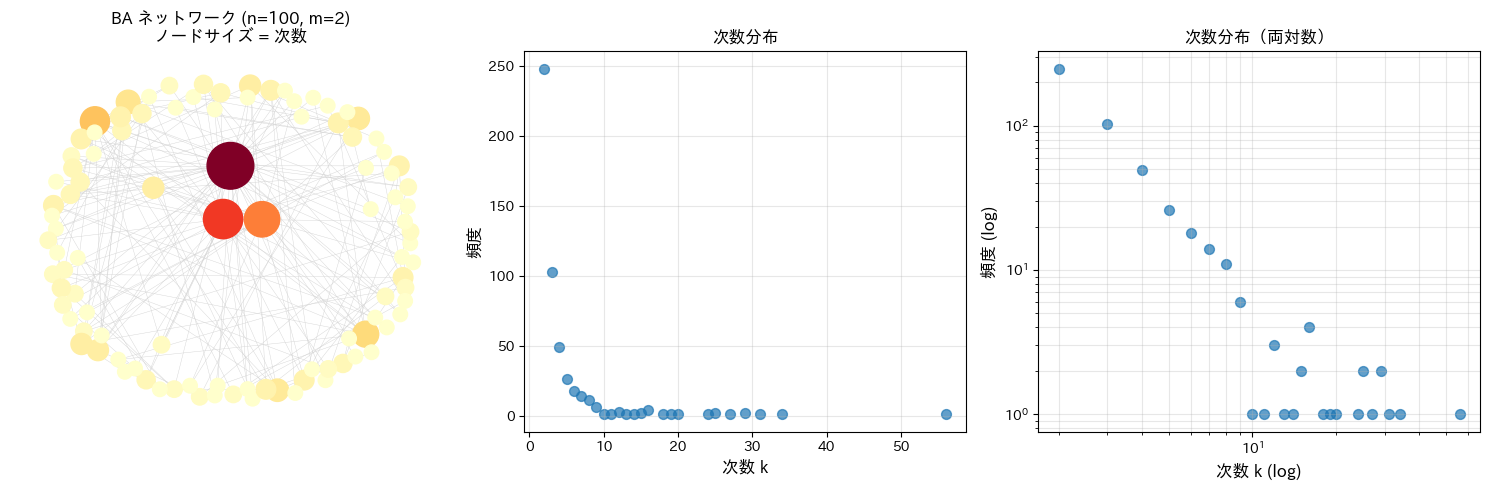

ノード数: 500
エッジ数: 997
最大次数: 56
平均次数: 3.99


In [3]:
def barabasi_albert_manual(n, m, m0=None, seed=None):
    """
    Barabási-Albertモデルの手動実装
    
    Parameters:
    -----------
    n : int
        最終的なノード数
    m : int
        各新規ノードが追加するエッジ数
    m0 : int or None
        初期ノード数（Noneの場合はm+1）
    seed : int or None
        乱数シード
    
    Returns:
    --------
    G : networkx.Graph
    history : dict
        成長過程の記録
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    if m0 is None:
        m0 = m + 1
    
    # 初期グラフ（完全グラフ）
    G = nx.complete_graph(m0)
    
    # 次数リスト（高速なサンプリング用）
    degree_list = []
    for node in G.nodes():
        degree_list.extend([node] * G.degree(node))
    
    history = {
        'node_count': [m0],
        'edge_count': [G.number_of_edges()],
        'max_degree': [max(d for n, d in G.degree())]
    }
    
    # ネットワーク成長
    for new_node in range(m0, n):
        G.add_node(new_node)
        
        # 優先的選択でm個のノードを選択
        targets = set()
        while len(targets) < m:
            # 次数に比例した確率でノードを選択
            target = random.choice(degree_list)
            if target != new_node and target not in targets:
                targets.add(target)
        
        # エッジを追加
        for target in targets:
            G.add_edge(new_node, target)
            # 次数リストを更新
            degree_list.append(new_node)
            degree_list.append(target)
        
        # 履歴を記録
        if new_node % 100 == 0 or new_node == n - 1:
            history['node_count'].append(G.number_of_nodes())
            history['edge_count'].append(G.number_of_edges())
            history['max_degree'].append(max(d for n, d in G.degree()))
    
    return G, history

# BAモデルの生成と可視化
G_ba, history = barabasi_albert_manual(500, m=2, seed=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 左: ネットワークの可視化
ax1 = axes[0]
# 小さなサブグラフで可視化
G_small = nx.barabasi_albert_graph(100, 2, seed=42)
pos = nx.spring_layout(G_small, seed=42, k=2)
degrees = dict(G_small.degree())
node_sizes = [degrees[n] * 30 + 50 for n in G_small.nodes()]
node_colors = [degrees[n] for n in G_small.nodes()]
nx.draw(G_small, pos, ax=ax1, node_size=node_sizes, node_color=node_colors,
        cmap=plt.cm.YlOrRd, edge_color='lightgray', width=0.3, with_labels=False)
ax1.set_title('BA ネットワーク (n=100, m=2)\nノードサイズ = 次数', fontsize=12)

# 中央: 次数分布
ax2 = axes[1]
degrees = [d for n, d in G_ba.degree()]
degree_counts = Counter(degrees)
x = list(degree_counts.keys())
y = list(degree_counts.values())
ax2.scatter(x, y, alpha=0.7, s=50)
ax2.set_xlabel('次数 k', fontsize=12)
ax2.set_ylabel('頻度', fontsize=12)
ax2.set_title('次数分布', fontsize=12)
ax2.grid(True, alpha=0.3)

# 右: 両対数プロット
ax3 = axes[2]
ax3.scatter(x, y, alpha=0.7, s=50)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('次数 k (log)', fontsize=12)
ax3.set_ylabel('頻度 (log)', fontsize=12)
ax3.set_title('次数分布（両対数）', fontsize=12)
ax3.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"ノード数: {G_ba.number_of_nodes()}")
print(f"エッジ数: {G_ba.number_of_edges()}")
print(f"最大次数: {max(degrees)}")
print(f"平均次数: {np.mean(degrees):.2f}")

## 3. べき乗則（Power Law）分布

### 3.1 べき乗則とは

BAモデルで生成されるネットワークの次数分布は**べき乗則**に従います：

$$P(k) \propto k^{-\gamma}$$

ここで $\gamma$ は指数（BAモデルでは理論値 $\gamma = 3$）。

両対数プロットで直線になることがべき乗則の特徴です：

$$\log P(k) = -\gamma \log k + \text{const}$$

### 3.2 べき乗則のフィッティング

n=500: 推定γ = 3.289 (理論値: 3.0)
n=2000: 推定γ = 3.272 (理論値: 3.0)
n=5000: 推定γ = 3.295 (理論値: 3.0)


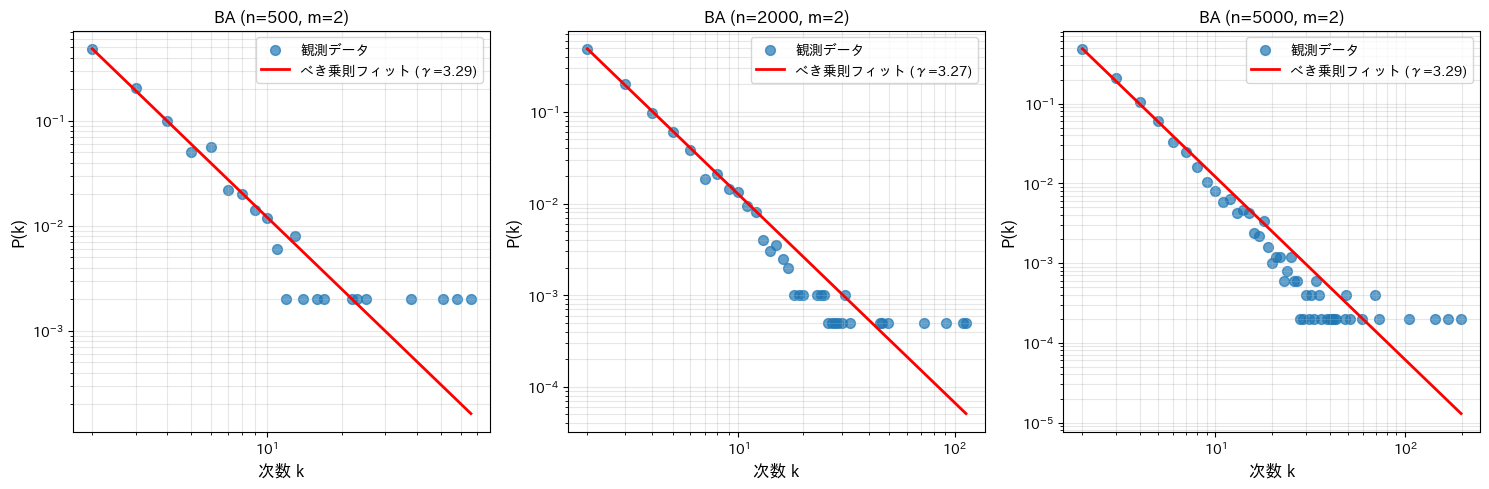

In [4]:
def fit_power_law(degrees, k_min=None):
    """
    次数分布にべき乗則をフィッティング
    
    Parameters:
    -----------
    degrees : list
        次数のリスト
    k_min : int or None
        フィッティングの最小次数
    
    Returns:
    --------
    gamma : float
        べき乗指数
    k_min : int
        使用した最小次数
    """
    degrees = np.array(degrees)
    
    if k_min is None:
        k_min = max(2, int(np.percentile(degrees, 10)))
    
    # k_min以上の次数のみ使用
    filtered_degrees = degrees[degrees >= k_min]
    
    # 最尤推定でγを推定
    # γ = 1 + n / Σ ln(k_i / k_min)
    n = len(filtered_degrees)
    if n == 0:
        return None, k_min
    
    gamma = 1 + n / np.sum(np.log(filtered_degrees / k_min))
    
    return gamma, k_min

def plot_power_law_fit(degrees, ax=None, title=""):
    """
    次数分布とべき乗則フィットを可視化
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # 次数分布（累積）
    degree_counts = Counter(degrees)
    k_values = np.array(sorted(degree_counts.keys()))
    counts = np.array([degree_counts[k] for k in k_values])
    
    # 確率密度
    p_values = counts / sum(counts)
    
    # プロット
    ax.scatter(k_values, p_values, alpha=0.7, s=50, label='観測データ')
    
    # べき乗則フィット
    gamma, k_min = fit_power_law(degrees)
    if gamma is not None:
        # フィット曲線
        k_fit = k_values[k_values >= k_min]
        # 正規化定数を推定
        p_kmin = p_values[k_values == k_min][0] if k_min in k_values else p_values[0]
        p_fit = p_kmin * (k_fit / k_min) ** (-gamma + 1)
        
        ax.plot(k_fit, p_fit, 'r-', linewidth=2, 
                label=f'べき乗則フィット (γ={gamma:.2f})')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('次数 k', fontsize=12)
    ax.set_ylabel('P(k)', fontsize=12)
    ax.set_title(title, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, which='both')
    
    return gamma

# 異なるサイズのBAネットワークでべき乗則を検証
sizes = [500, 2000, 5000]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, n in zip(axes, sizes):
    G = nx.barabasi_albert_graph(n, 2, seed=42)
    degrees = [d for _, d in G.degree()]
    gamma = plot_power_law_fit(degrees, ax, f'BA (n={n}, m=2)')
    print(f"n={n}: 推定γ = {gamma:.3f} (理論値: 3.0)")

plt.tight_layout()
plt.show()

### 3.3 べき乗則と指数分布の比較

べき乗則分布は指数分布と比べて「ファットテール（重い裾）」を持ちます。

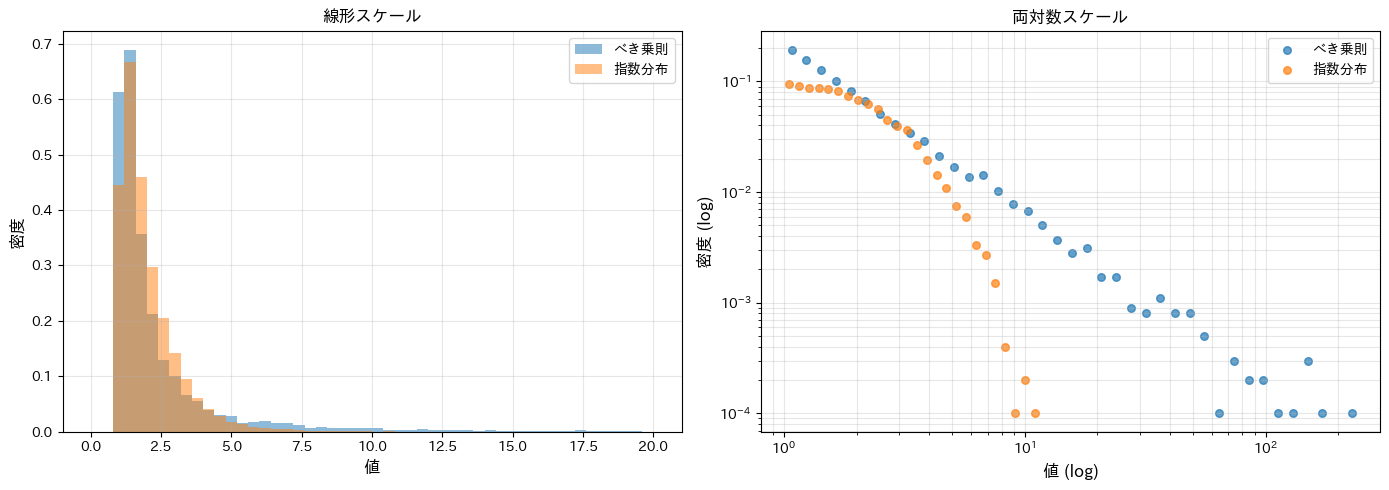

べき乗則: 最大値 = 232.4
指数分布: 最大値 = 10.5

べき乗則は非常に大きな値（ハブ）を含みやすい


In [5]:
# べき乗則と指数分布の比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# サンプル生成
n_samples = 10000

# べき乗則（パレート分布）
gamma = 2.5
x_min = 1
power_law_samples = (np.random.pareto(gamma - 1, n_samples) + 1) * x_min

# 指数分布
lambda_param = 1.0
exp_samples = np.random.exponential(1/lambda_param, n_samples) + 1

# 線形プロット
ax1 = axes[0]
ax1.hist(power_law_samples, bins=50, alpha=0.5, label='べき乗則', density=True, range=(0, 20))
ax1.hist(exp_samples, bins=50, alpha=0.5, label='指数分布', density=True, range=(0, 20))
ax1.set_xlabel('値', fontsize=12)
ax1.set_ylabel('密度', fontsize=12)
ax1.set_title('線形スケール', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 両対数プロット
ax2 = axes[1]

# べき乗則のヒストグラム
counts_pl, bins_pl = np.histogram(power_law_samples, bins=np.logspace(0, 3, 50))
bin_centers_pl = (bins_pl[:-1] + bins_pl[1:]) / 2
ax2.scatter(bin_centers_pl[counts_pl > 0], counts_pl[counts_pl > 0] / n_samples, 
            alpha=0.7, label='べき乗則', s=30)

# 指数分布のヒストグラム
counts_exp, bins_exp = np.histogram(exp_samples, bins=np.logspace(0, 2, 50))
bin_centers_exp = (bins_exp[:-1] + bins_exp[1:]) / 2
ax2.scatter(bin_centers_exp[counts_exp > 0], counts_exp[counts_exp > 0] / n_samples,
            alpha=0.7, label='指数分布', s=30)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('値 (log)', fontsize=12)
ax2.set_ylabel('密度 (log)', fontsize=12)
ax2.set_title('両対数スケール', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"べき乗則: 最大値 = {max(power_law_samples):.1f}")
print(f"指数分布: 最大値 = {max(exp_samples):.1f}")
print("\nべき乗則は非常に大きな値（ハブ）を含みやすい")

## 4. ネットワーク成長モデルの比較

### 4.1 異なる成長モデル

優先的選択以外にも様々なネットワーク成長モデルがあります。

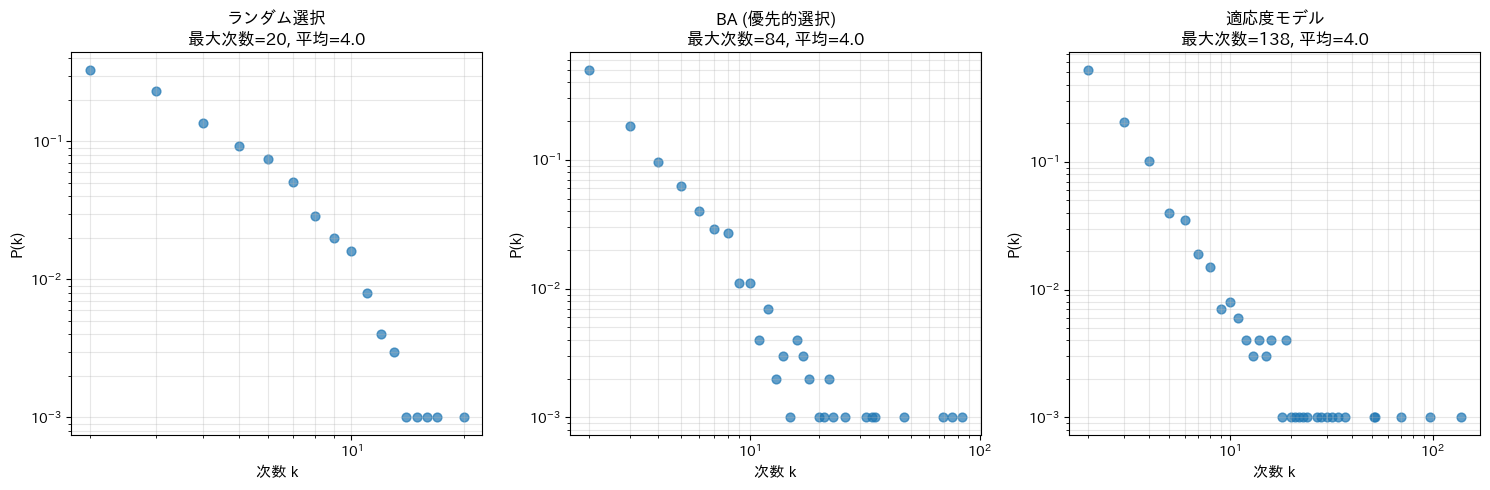


モデル比較:
--------------------------------------------------
ランダム選択: max=20, γ≈2.81
BA (優先的選択): max=84, γ≈3.28
適応度モデル: max=138, γ≈3.50


In [6]:
def random_attachment_model(n, m, seed=None):
    """
    ランダム選択モデル（優先的選択なし）
    新しいノードがランダムにm個の既存ノードに接続
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.complete_graph(m + 1)
    
    for new_node in range(m + 1, n):
        G.add_node(new_node)
        # ランダムにm個のノードを選択
        targets = random.sample(list(G.nodes())[:-1], m)
        for target in targets:
            G.add_edge(new_node, target)
    
    return G

def fitness_model(n, m, seed=None):
    """
    適応度モデル（Bianconi-Barabási）
    各ノードに適応度を割り当て、選択確率 ∝ 適応度 × 次数
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    G = nx.complete_graph(m + 1)
    
    # 適応度を割り当て（一様分布）
    fitness = {i: np.random.uniform(0.5, 1.5) for i in range(m + 1)}
    
    for new_node in range(m + 1, n):
        G.add_node(new_node)
        fitness[new_node] = np.random.uniform(0.5, 1.5)
        
        # 選択確率 ∝ 適応度 × 次数
        probs = []
        nodes = list(G.nodes())[:-1]  # 新ノード以外
        for node in nodes:
            prob = fitness[node] * G.degree(node)
            probs.append(prob)
        
        probs = np.array(probs)
        probs /= probs.sum()
        
        targets = np.random.choice(nodes, size=m, replace=False, p=probs)
        for target in targets:
            G.add_edge(new_node, target)
    
    return G

# モデルの比較
n = 1000
m = 2

models = {
    'ランダム選択': random_attachment_model(n, m, seed=42),
    'BA (優先的選択)': nx.barabasi_albert_graph(n, m, seed=42),
    '適応度モデル': fitness_model(n, m, seed=42)
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, G) in zip(axes, models.items()):
    degrees = [d for _, d in G.degree()]
    
    # 次数分布
    degree_counts = Counter(degrees)
    k_values = sorted(degree_counts.keys())
    p_values = [degree_counts[k] / n for k in k_values]
    
    ax.scatter(k_values, p_values, alpha=0.7, s=40)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('次数 k', fontsize=11)
    ax.set_ylabel('P(k)', fontsize=11)
    ax.set_title(f'{name}\n最大次数={max(degrees)}, 平均={np.mean(degrees):.1f}', fontsize=12)
    ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nモデル比較:")
print("-" * 50)
for name, G in models.items():
    degrees = [d for _, d in G.degree()]
    gamma, _ = fit_power_law(degrees)
    gamma_str = f"{gamma:.2f}" if gamma else "N/A"
    print(f"{name}: max={max(degrees)}, γ≈{gamma_str}")

### 4.2 次数分布の時間発展

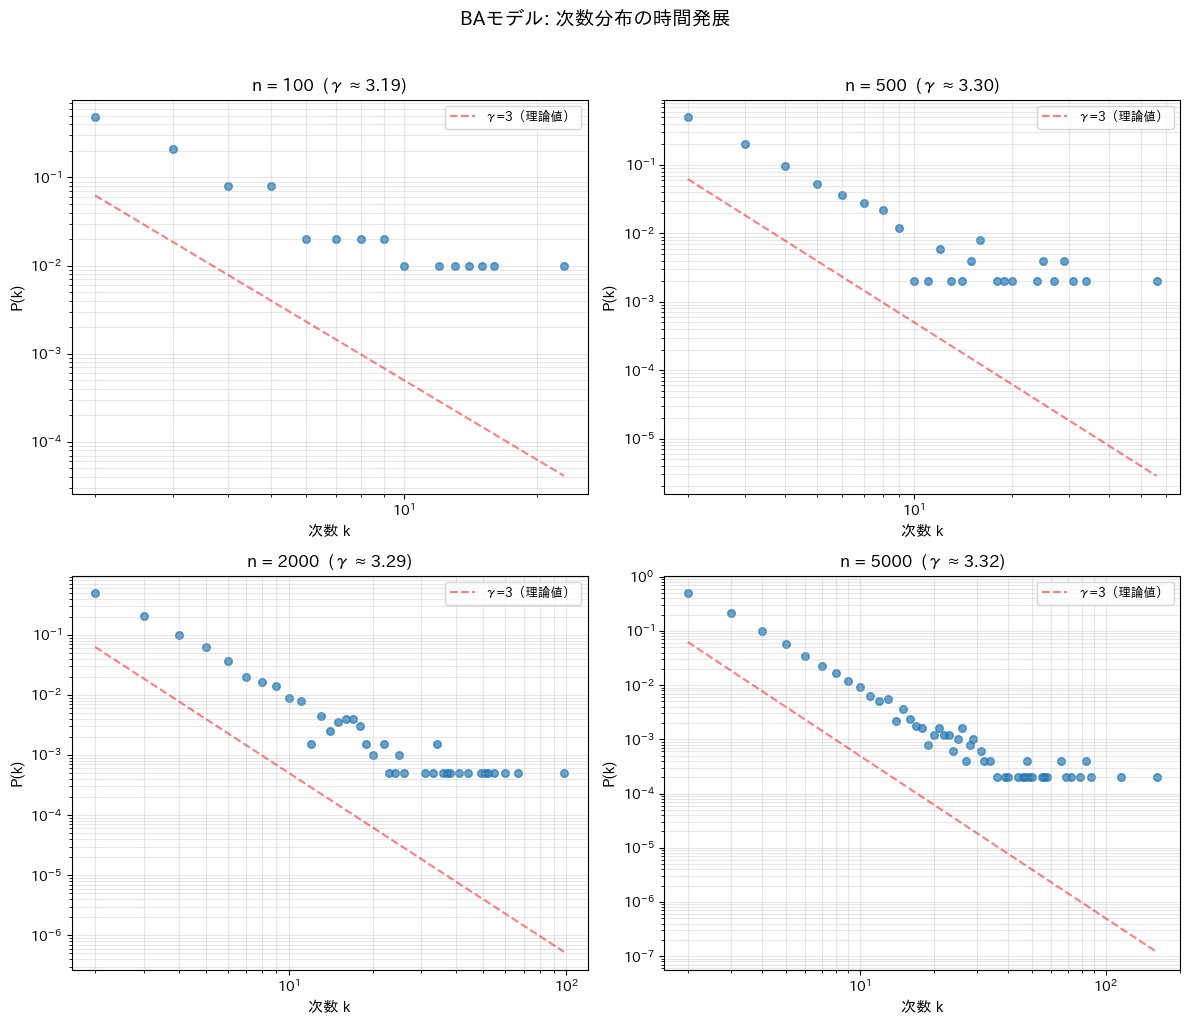

In [7]:
# BAモデルにおける次数分布の時間発展
def ba_growth_analysis(final_n, m, checkpoints, seed=42):
    """
    BAモデルの成長過程を分析
    """
    random.seed(seed)
    np.random.seed(seed)
    
    G = nx.complete_graph(m + 1)
    degree_list = []
    for node in G.nodes():
        degree_list.extend([node] * G.degree(node))
    
    results = {}
    
    for new_node in range(m + 1, final_n):
        G.add_node(new_node)
        
        targets = set()
        while len(targets) < m:
            target = random.choice(degree_list)
            if target != new_node and target not in targets:
                targets.add(target)
        
        for target in targets:
            G.add_edge(new_node, target)
            degree_list.append(new_node)
            degree_list.append(target)
        
        if new_node + 1 in checkpoints:
            results[new_node + 1] = [d for _, d in G.degree()]
    
    return results

checkpoints = [100, 500, 2000, 5000]
results = ba_growth_analysis(5000, 2, checkpoints)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, n in zip(axes, checkpoints):
    degrees = results[n]
    degree_counts = Counter(degrees)
    k_values = sorted(degree_counts.keys())
    p_values = [degree_counts[k] / n for k in k_values]
    
    ax.scatter(k_values, p_values, alpha=0.7, s=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('次数 k', fontsize=11)
    ax.set_ylabel('P(k)', fontsize=11)
    
    gamma, _ = fit_power_law(degrees)
    ax.set_title(f'n = {n}  (γ ≈ {gamma:.2f})', fontsize=12)
    ax.grid(True, alpha=0.3, which='both')
    
    # べき乗則の参考線（γ=3）
    k_ref = np.array(k_values, dtype=float)
    p_ref = 0.5 * k_ref ** (-3)
    ax.plot(k_ref, p_ref, 'r--', alpha=0.5, label='γ=3（理論値）')
    ax.legend(fontsize=9)

plt.suptitle('BAモデル: 次数分布の時間発展', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. ハブの形成と「富める者はますます富む」

### 5.1 初期ノードの優位性

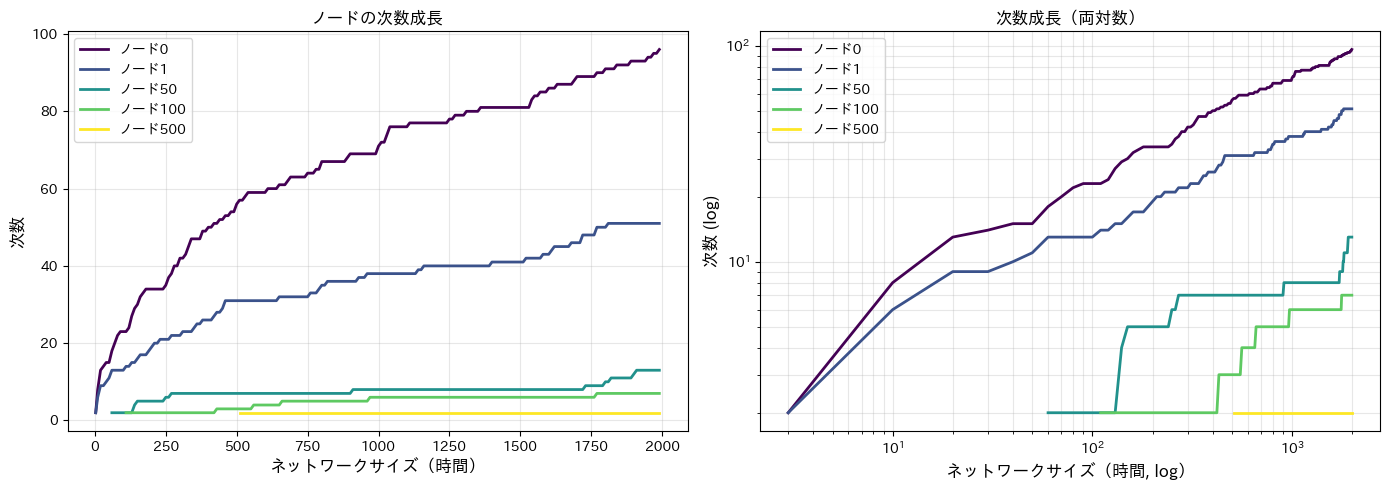


最終次数:
  ノード0 (t=0で追加): 次数 = 96
  ノード1 (t=1で追加): 次数 = 51
  ノード50 (t=50で追加): 次数 = 13
  ノード100 (t=100で追加): 次数 = 7
  ノード500 (t=500で追加): 次数 = 2


In [8]:
def track_node_degrees(n, m, tracked_nodes, seed=42):
    """
    特定ノードの次数の時間発展を追跡
    """
    random.seed(seed)
    np.random.seed(seed)
    
    G = nx.complete_graph(m + 1)
    degree_list = []
    for node in G.nodes():
        degree_list.extend([node] * G.degree(node))
    
    history = {node: [G.degree(node) if node < m + 1 else 0] for node in tracked_nodes}
    time_points = [m + 1]
    
    for new_node in range(m + 1, n):
        G.add_node(new_node)
        
        targets = set()
        while len(targets) < m:
            target = random.choice(degree_list)
            if target != new_node and target not in targets:
                targets.add(target)
        
        for target in targets:
            G.add_edge(new_node, target)
            degree_list.append(new_node)
            degree_list.append(target)
        
        # 追跡ノードの次数を記録
        if new_node % 10 == 0:
            time_points.append(new_node)
            for node in tracked_nodes:
                if node in G:
                    history[node].append(G.degree(node))
                else:
                    history[node].append(0)
    
    return time_points, history

# 異なる時期に追加されたノードの次数変化を追跡
tracked = [0, 1, 50, 100, 500]  # ノードID（追加時期を表す）
time_points, history = track_node_degrees(2000, 2, tracked)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 次数の時間発展
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(tracked)))
for node, color in zip(tracked, colors):
    # ノードが存在する時点から
    valid_times = [t for t in time_points if t > node]
    valid_degrees = history[node][len(time_points) - len(valid_times):]
    if valid_times:
        ax1.plot(valid_times, valid_degrees, label=f'ノード{node}', 
                 color=color, linewidth=2)

ax1.set_xlabel('ネットワークサイズ（時間）', fontsize=12)
ax1.set_ylabel('次数', fontsize=12)
ax1.set_title('ノードの次数成長', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: 対数スケール
ax2 = axes[1]
for node, color in zip(tracked, colors):
    valid_times = [t for t in time_points if t > node]
    valid_degrees = history[node][len(time_points) - len(valid_times):]
    if valid_times and min(valid_degrees) > 0:
        ax2.plot(valid_times, valid_degrees, label=f'ノード{node}', 
                 color=color, linewidth=2)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('ネットワークサイズ（時間, log）', fontsize=12)
ax2.set_ylabel('次数 (log)', fontsize=12)
ax2.set_title('次数成長（両対数）', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\n最終次数:")
for node in tracked:
    print(f"  ノード{node} (t={node}で追加): 次数 = {history[node][-1]}")

### 5.2 次数の理論的成長

BAモデルでは、時刻 $t_i$ に追加されたノード $i$ の次数は、時刻 $t$ で平均的に次のように成長します：

$$k_i(t) \approx m \sqrt{\frac{t}{t_i}}$$

これは「先に参加したノードほど大きな次数を持つ」ことを示しています。

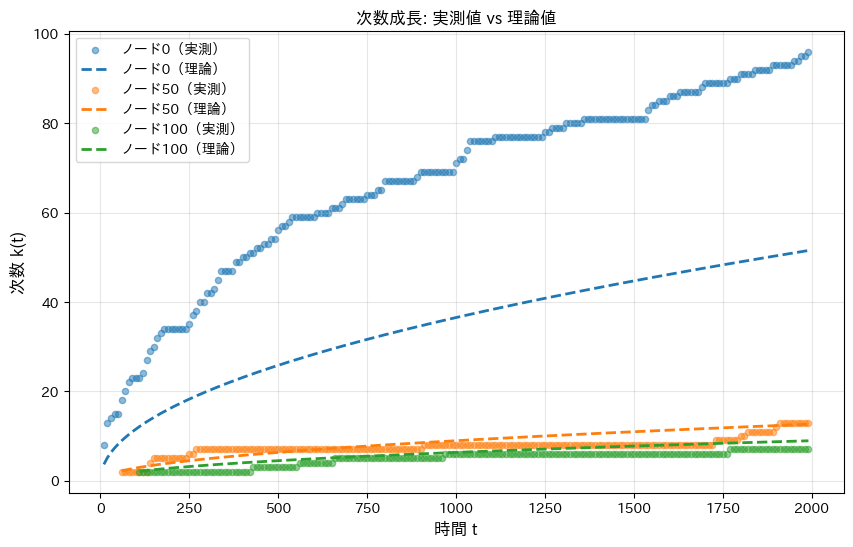

理論式: k(t) ≈ m√(t/t_i)
早期に参加したノードほど、同じ時点でより高い次数を持つ


In [9]:
# 理論的成長曲線との比較
fig, ax = plt.subplots(figsize=(10, 6))

m = 2
for node in [0, 50, 100]:
    valid_times = np.array([t for t in time_points if t > max(node, m+1)])
    valid_degrees = np.array(history[node][len(time_points) - len(valid_times):])
    
    # 実測値
    ax.scatter(valid_times, valid_degrees, alpha=0.5, s=20, label=f'ノード{node}（実測）')
    
    # 理論曲線
    t_i = max(node, m + 1)
    theoretical = m * np.sqrt(valid_times / t_i)
    ax.plot(valid_times, theoretical, '--', linewidth=2, label=f'ノード{node}（理論）')

ax.set_xlabel('時間 t', fontsize=12)
ax.set_ylabel('次数 k(t)', fontsize=12)
ax.set_title('次数成長: 実測値 vs 理論値', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("理論式: k(t) ≈ m√(t/t_i)")
print("早期に参加したノードほど、同じ時点でより高い次数を持つ")

## 6. 優先的選択の測定

### 6.1 実ネットワークでの検証

実際のネットワークが優先的選択に従っているかを検証する方法を学びます。

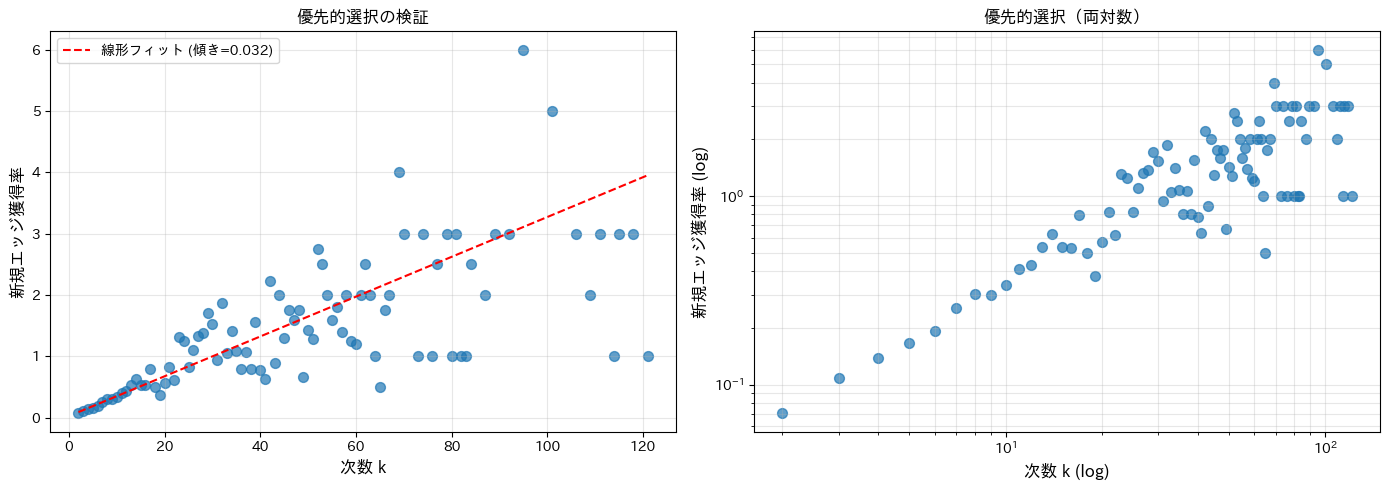

線形フィットの傾き: 0.0324
R² = 0.7888

傾き > 0 は優先的選択の存在を示す
理想的な優先的選択では、獲得率は次数に比例する


In [10]:
def measure_preferential_attachment(G_snapshots):
    """
    時系列スナップショットから優先的選択を測定
    
    Parameters:
    -----------
    G_snapshots : list of networkx.Graph
        時系列順のネットワークスナップショット
    
    Returns:
    --------
    results : dict
        次数ごとの新規エッジ獲得率
    """
    if len(G_snapshots) < 2:
        return None
    
    degree_to_new_edges = {}
    degree_counts = {}
    
    for i in range(len(G_snapshots) - 1):
        G_t = G_snapshots[i]
        G_t1 = G_snapshots[i + 1]
        
        # 時刻tでの各ノードの次数
        degrees_t = dict(G_t.degree())
        
        # 新規エッジ
        edges_t = set(G_t.edges())
        edges_t1 = set(G_t1.edges())
        new_edges = edges_t1 - edges_t
        
        # 各ノードが獲得した新規エッジ数
        for u, v in new_edges:
            for node in [u, v]:
                if node in degrees_t:
                    k = degrees_t[node]
                    if k not in degree_to_new_edges:
                        degree_to_new_edges[k] = 0
                        degree_counts[k] = 0
                    degree_to_new_edges[k] += 1
        
        # 各次数のノード数をカウント
        for node, k in degrees_t.items():
            if k not in degree_counts:
                degree_counts[k] = 0
            degree_counts[k] += 1
    
    # 次数ごとの平均新規エッジ獲得率
    attachment_rate = {}
    for k in degree_to_new_edges:
        if degree_counts[k] > 0:
            attachment_rate[k] = degree_to_new_edges[k] / degree_counts[k]
    
    return attachment_rate

# BAモデルでの優先的選択の検証
def generate_ba_snapshots(n_final, m, n_snapshots=20, seed=42):
    """BAモデルのスナップショットを生成"""
    random.seed(seed)
    np.random.seed(seed)
    
    G = nx.complete_graph(m + 1)
    degree_list = []
    for node in G.nodes():
        degree_list.extend([node] * G.degree(node))
    
    snapshot_times = np.linspace(m + 1, n_final, n_snapshots, dtype=int)
    snapshots = []
    
    for new_node in range(m + 1, n_final):
        G.add_node(new_node)
        
        targets = set()
        while len(targets) < m:
            target = random.choice(degree_list)
            if target != new_node and target not in targets:
                targets.add(target)
        
        for target in targets:
            G.add_edge(new_node, target)
            degree_list.append(new_node)
            degree_list.append(target)
        
        if new_node in snapshot_times:
            snapshots.append(G.copy())
    
    return snapshots

# スナップショット生成と測定
snapshots = generate_ba_snapshots(3000, 2, n_snapshots=30)
attachment_rate = measure_preferential_attachment(snapshots)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 線形スケール
ax1 = axes[0]
k_values = sorted(attachment_rate.keys())
rates = [attachment_rate[k] for k in k_values]
ax1.scatter(k_values, rates, alpha=0.7, s=50)

# 線形フィット
slope, intercept, r, p, se = stats.linregress(k_values[:20], rates[:20])
ax1.plot(k_values, slope * np.array(k_values) + intercept, 'r--', 
         label=f'線形フィット (傾き={slope:.3f})')

ax1.set_xlabel('次数 k', fontsize=12)
ax1.set_ylabel('新規エッジ獲得率', fontsize=12)
ax1.set_title('優先的選択の検証', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: 両対数スケール
ax2 = axes[1]
ax2.scatter(k_values, rates, alpha=0.7, s=50)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('次数 k (log)', fontsize=12)
ax2.set_ylabel('新規エッジ獲得率 (log)', fontsize=12)
ax2.set_title('優先的選択（両対数）', fontsize=12)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"線形フィットの傾き: {slope:.4f}")
print(f"R² = {r**2:.4f}")
print("\n傾き > 0 は優先的選択の存在を示す")
print("理想的な優先的選択では、獲得率は次数に比例する")

## 7. 拡張モデル

### 7.1 非線形優先的選択

選択確率が次数の非線形関数の場合：

$$\Pi(k) \propto k^\alpha$$

- $\alpha = 1$: 線形優先的選択（BA）
- $\alpha > 1$: 超線形（より極端なハブ形成）
- $\alpha < 1$: 劣線形（より均一な分布）

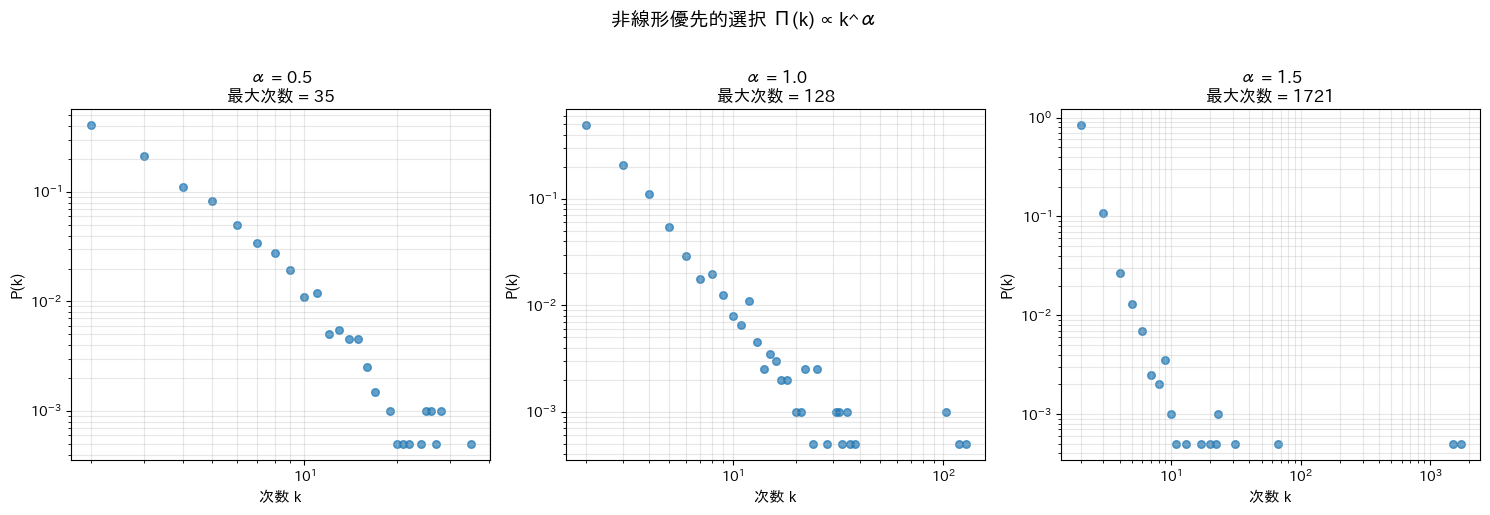

α < 1: より均一な次数分布（べき乗則が弱まる）
α = 1: 標準的なBA（べき乗則γ≈3）
α > 1: より極端なハブ形成（単一ノードへの集中）


In [11]:
def nonlinear_pa_model(n, m, alpha=1.0, seed=None):
    """
    非線形優先的選択モデル
    選択確率 ∝ k^α
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    G = nx.complete_graph(m + 1)
    
    for new_node in range(m + 1, n):
        G.add_node(new_node)
        
        # 選択確率を計算
        nodes = list(G.nodes())[:-1]
        degrees = np.array([G.degree(node) for node in nodes])
        probs = degrees ** alpha
        probs = probs / probs.sum()
        
        # m個のノードを選択
        targets = np.random.choice(nodes, size=m, replace=False, p=probs)
        for target in targets:
            G.add_edge(new_node, target)
    
    return G

# 異なるαでの比較
alphas = [0.5, 1.0, 1.5]
n = 2000
m = 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, alpha in zip(axes, alphas):
    G = nonlinear_pa_model(n, m, alpha=alpha, seed=42)
    degrees = [d for _, d in G.degree()]
    
    degree_counts = Counter(degrees)
    k_values = sorted(degree_counts.keys())
    p_values = [degree_counts[k] / n for k in k_values]
    
    ax.scatter(k_values, p_values, alpha=0.7, s=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('次数 k', fontsize=11)
    ax.set_ylabel('P(k)', fontsize=11)
    ax.set_title(f'α = {alpha}\n最大次数 = {max(degrees)}', fontsize=12)
    ax.grid(True, alpha=0.3, which='both')

plt.suptitle('非線形優先的選択 Π(k) ∝ k^α', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("α < 1: より均一な次数分布（べき乗則が弱まる）")
print("α = 1: 標準的なBA（べき乗則γ≈3）")
print("α > 1: より極端なハブ形成（単一ノードへの集中）")

### 7.2 初期魅力度モデル（Initial Attractiveness）

新しいノードにも初期の「魅力度」を与えるモデル：

$$\Pi(k) \propto k + a$$

ここで $a$ は初期魅力度パラメータ。

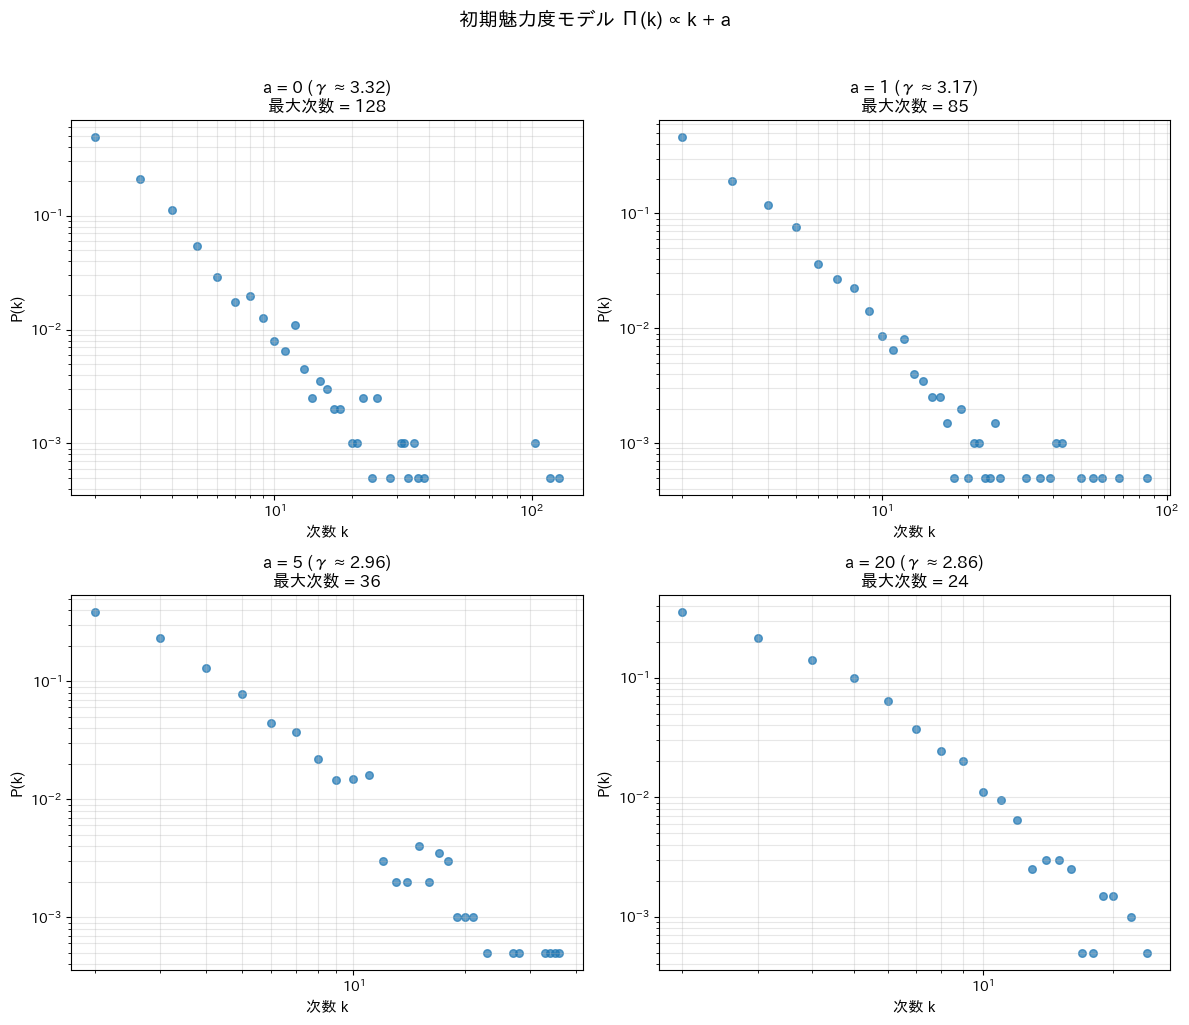

a が大きいほど:
  - 新しいノードも接続を獲得しやすい
  - 次数分布はより均一に近づく
  - べき乗指数γは大きくなる


In [12]:
def initial_attractiveness_model(n, m, a=1.0, seed=None):
    """
    初期魅力度モデル
    選択確率 ∝ k + a
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    G = nx.complete_graph(m + 1)
    
    for new_node in range(m + 1, n):
        G.add_node(new_node)
        
        nodes = list(G.nodes())[:-1]
        degrees = np.array([G.degree(node) + a for node in nodes])
        probs = degrees / degrees.sum()
        
        targets = np.random.choice(nodes, size=m, replace=False, p=probs)
        for target in targets:
            G.add_edge(new_node, target)
    
    return G

# 異なる初期魅力度での比較
a_values = [0, 1, 5, 20]
n = 2000
m = 2

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, a in zip(axes, a_values):
    G = initial_attractiveness_model(n, m, a=a, seed=42)
    degrees = [d for _, d in G.degree()]
    
    degree_counts = Counter(degrees)
    k_values = sorted(degree_counts.keys())
    p_values = [degree_counts[k] / n for k in k_values]
    
    ax.scatter(k_values, p_values, alpha=0.7, s=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('次数 k', fontsize=11)
    ax.set_ylabel('P(k)', fontsize=11)
    
    gamma, _ = fit_power_law(degrees)
    ax.set_title(f'a = {a} (γ ≈ {gamma:.2f})\n最大次数 = {max(degrees)}', fontsize=12)
    ax.grid(True, alpha=0.3, which='both')

plt.suptitle('初期魅力度モデル Π(k) ∝ k + a', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("a が大きいほど:")
print("  - 新しいノードも接続を獲得しやすい")
print("  - 次数分布はより均一に近づく")
print("  - べき乗指数γは大きくなる")

## 8. まとめ

### 主要な概念

| 概念 | 説明 |
|------|------|
| 優先的選択 | 既に接続の多いノードほど、新しい接続を獲得しやすい |
| べき乗則 | P(k) ∝ k^(-γ)、ハブの存在を特徴づける |
| スケールフリー | 次数分布にスケール（特徴的な値）がない |
| マタイ効果 | 「持てる者はさらに与えられる」累積的優位性 |

### 重要なポイント

1. **BAモデル**: 成長 + 優先的選択 → べき乗則（γ ≈ 3）
2. **早期参加者の優位**: 先に参加したノードほどハブになりやすい
3. **べき乗則の検出**: 両対数プロットでの直線性
4. **拡張モデル**: 非線形PA、適応度、初期魅力度など

### 実世界への応用

- **WWW**: 人気サイトへのリンク集中
- **学術引用**: 有名論文の被引用数の増加
- **SNS**: インフルエンサーのフォロワー獲得
- **都市成長**: 大都市への人口集中
- **市場集中**: プラットフォーム企業の寡占化

---

## 練習問題

### 問題1: パラメータmの影響

BAモデルでパラメータm（各新規ノードが追加するエッジ数）を1, 3, 5と変化させたときの次数分布を比較してください。それぞれn=2000のネットワークを生成し、べき乗指数γを推定してください。

<details>
<summary>解答例</summary>

```python
m_values = [1, 3, 5]
n = 2000

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, m in zip(axes, m_values):
    G = nx.barabasi_albert_graph(n, m, seed=42)
    degrees = [d for _, d in G.degree()]
    
    degree_counts = Counter(degrees)
    k_values = sorted(degree_counts.keys())
    p_values = [degree_counts[k] / n for k in k_values]
    
    ax.scatter(k_values, p_values, alpha=0.7, s=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('次数 k')
    ax.set_ylabel('P(k)')
    
    gamma, _ = fit_power_law(degrees)
    ax.set_title(f'm = {m}\nγ ≈ {gamma:.2f}, 平均次数 = {np.mean(degrees):.1f}')
    ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# mが大きいほど平均次数は増加するが、べき乗指数γは約3で安定
```

</details>

### 問題2: ランダム vs 優先的選択

同じノード数（n=1000）、同じエッジ数で、ランダム選択モデルとBAモデルのネットワークを比較してください。以下の指標を計算・比較してください：
1. 次数分布の標準偏差
2. 最大次数
3. クラスタリング係数

<details>
<summary>解答例</summary>

```python
n = 1000
m = 3

G_random = random_attachment_model(n, m, seed=42)
G_ba = nx.barabasi_albert_graph(n, m, seed=42)

models = {'ランダム選択': G_random, 'BA (優先的選択)': G_ba}

print("モデル比較:")
print("-" * 60)
print(f"{'指標':<20} {'ランダム選択':<20} {'BA (優先的選択)':<20}")
print("-" * 60)

for metric in ['エッジ数', '次数の標準偏差', '最大次数', 'クラスタリング係数']:
    values = []
    for name, G in models.items():
        degrees = [d for _, d in G.degree()]
        if metric == 'エッジ数':
            values.append(G.number_of_edges())
        elif metric == '次数の標準偏差':
            values.append(np.std(degrees))
        elif metric == '最大次数':
            values.append(max(degrees))
        elif metric == 'クラスタリング係数':
            values.append(nx.average_clustering(G))
    
    print(f"{metric:<20} {values[0]:<20.3f} {values[1]:<20.3f}")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, G) in zip(axes, models.items()):
    degrees = [d for _, d in G.degree()]
    ax.hist(degrees, bins=30, alpha=0.7, edgecolor='black')
    ax.set_xlabel('次数')
    ax.set_ylabel('頻度')
    ax.set_title(f'{name}\n(std={np.std(degrees):.2f}, max={max(degrees)})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
```

</details>

### 問題3: べき乗則のフィッティング精度

BAモデル（n=5000, m=2）で生成したネットワークに対して、異なるk_min（最小次数の閾値）でべき乗則をフィッティングし、推定されるγの値がどのように変化するか調べてください。k_min = 2, 5, 10, 20 で比較してください。

<details>
<summary>解答例</summary>

```python
G = nx.barabasi_albert_graph(5000, 2, seed=42)
degrees = [d for _, d in G.degree()]

k_min_values = [2, 5, 10, 20]

print("k_minによるγ推定値の変化:")
print("-" * 40)

fig, ax = plt.subplots(figsize=(10, 6))

# 次数分布をプロット
degree_counts = Counter(degrees)
k_values = sorted(degree_counts.keys())
p_values = [degree_counts[k] / len(degrees) for k in k_values]
ax.scatter(k_values, p_values, alpha=0.5, s=30, label='観測データ')

colors = plt.cm.viridis(np.linspace(0, 1, len(k_min_values)))

for k_min, color in zip(k_min_values, colors):
    gamma, _ = fit_power_law(degrees, k_min=k_min)
    print(f"k_min = {k_min}: γ = {gamma:.3f}")
    
    # フィット曲線
    k_fit = np.array([k for k in k_values if k >= k_min])
    p_kmin = p_values[k_values.index(k_min)] if k_min in k_values else p_values[0]
    p_fit = p_kmin * (k_fit / k_min) ** (-gamma + 1)
    ax.plot(k_fit, p_fit, '-', color=color, linewidth=2, 
            label=f'k_min={k_min}, γ={gamma:.2f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('次数 k')
ax.set_ylabel('P(k)')
ax.set_title('べき乗則フィッティング: k_minの影響')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
plt.show()

print("\n理論値 γ = 3 に近い推定を得るには適切なk_minの選択が重要")
```

</details>

---

## 参考文献

- Barabási, A. L., & Albert, R. (1999). Emergence of scaling in random networks. Science, 286(5439), 509-512.
- Price, D. D. S. (1976). A general theory of bibliometric and other cumulative advantage processes. Journal of the American Society for Information Science.
- Newman, M. E. (2005). Power laws, Pareto distributions and Zipf's law. Contemporary physics, 46(5), 323-351.
- Merton, R. K. (1968). The Matthew effect in science. Science, 159(3810), 56-63.
- Clauset, A., Shalizi, C. R., & Newman, M. E. (2009). Power-law distributions in empirical data. SIAM review, 51(4), 661-703.